# JRAP: JPEG Resistant Adversarial Perturbations to Disrupt Diffusion Based Inpainting

Minimal demonstration.

In [1]:
import time

start_time = time.time()

In [ ]:
import argparse
import gc

import matplotlib.pyplot as plt
import torch
from jrap import disrupt
from PIL import Image
from sd import Inference
from sd import StableDiffusionInpaint
from text_optimising import SemanticCentroids
from text_optimising import TextOptimizer
from torchvision import transforms
from utils import load_images
from utils import prepare_mask_and_masked
from utils import prepare_masks
from utils import process_images
from utils import recover_image

torch.backends.cuda.matmul.allow_tf32 = True
to_pil = transforms.ToPILImage()

device = "cuda"
dtype = torch.float16

## Hyperparameters

In [3]:
model_version = "stabilityai/stable-diffusion-2-inpainting"


def dict_to_args_parser():
  args_dict = {
      "prompt_len": 16,
      "iter": 3000,
      "lr": 0.1,
      "weight_decay": 0.1,
      "prompt_bs": 1,
      "loss_weight": 1.0,
      "print_step": 100,
      "batch_size": 1,
      "clip_model": "ViT-H-14",
      "clip_pretrain": "laion2b_s32b_b79k"
  }
  parser = argparse.ArgumentParser()
  for key, value in args_dict.items():
    parser.add_argument(f'--{key}', default=value, type=type(value))
  return parser.parse_args([])


args = dict_to_args_parser()
jrap_args = {
    "image_size": 512,
    "image_size_2d": (512, 512),
    "image_folder": "../tests/",
    "image_filenames": ["001"],
    "num_inference_steps": 4,
    "evaluation_metric": "COS_NORMED",
    "t_schedule": [720],
    "t_schedule_bound": 10,
    "centroids_n_samples": 50,
    "loss_depth": [4096, 1024, 256, 64],
    "iters": 268,
    "grad_reps": 7,
    "loss_mask": True,
    "eps": 13,
    "step_size": 3.0,
    "pixel_loss": 0
}

jrap_type = "diffjpeg"
if jrap_type == "original":
  diffjpeg = False
else:
  diffjpeg = True

DCS = False
username = "sneakers-pretrained-models"
if DCS:
  models_path = f"/dcs/large/{username}"
else:
  models_path = None

## Generate Perturbations

In [4]:
filename = jrap_args["image_filenames"][0]
# Load Stable Diffusion Models
inpaint_model = StableDiffusionInpaint(models_path=models_path)
pipe_inpaint = inpaint_model.get_pipeline()

# Get Tokenizers
tokenizer = pipe_inpaint.tokenizer
token_embedding = pipe_inpaint.text_encoder.text_model.embeddings.token_embedding

# Load masked and original images.
original_image, masked_image_original, masked_image = load_images(
    jrap_args['image_folder'], filename, jrap_args["image_size_2d"]
)

# Load token embeddings
current_mask, current_masked_image = prepare_masks(original_image, masked_image)
all_latents, masked_image_latents, mask = process_images(
    pipe_inpaint, original_image, current_mask, current_masked_image,
    jrap_args["image_size"]
)

# Optimise text embeddings using Token Projective Embedding Optimisation
print("Optimising text embeddings...")
optimizer = TextOptimizer(
    tokenizer, token_embedding, args, device, pipe_inpaint, all_latents, mask,
    masked_image_latents
)
text_embeddings = optimizer.optimize()
del optimizer
del all_latents
del masked_image_latents
del mask

input_text_embeddings = torch.cat([text_embeddings.detach()] * 2)

# Using Monte Carlo Sampling to construct Semantic Centroids
SEED = 786349
torch.manual_seed(SEED)

# Prepare the masked image and mask
current_mask, current_masked_image = prepare_mask_and_masked(
    original_image, masked_image
)
del original_image, masked_image

current_mask = current_mask.to(dtype=dtype, device=device)
current_masked_image = current_masked_image.to(dtype=dtype, device=device)
print("Monte Carlo Sampling to construct Semantic Centroids...")
processor = SemanticCentroids(
    pipe_inpaint, device, dtype, jrap_args["image_size"],
    jrap_args["num_inference_steps"], input_text_embeddings
)
attn_controller = processor.get_attention(
    current_mask, jrap_args["evaluation_metric"], jrap_args["loss_depth"]
)
processor.attention_processors(attn_controller)
text_embeddings = processor.generate_samples(
    current_mask, current_masked_image, jrap_args["t_schedule"],
    jrap_args["t_schedule_bound"], jrap_args["centroids_n_samples"],
    attn_controller
)

pipe_inpaint.text_encoder = pipe_inpaint.text_encoder.to(device="cpu")
pipe_inpaint.vae.decoder = pipe_inpaint.vae.decoder.to(device="cpu")
pipe_inpaint.vae.post_quant_conv = pipe_inpaint.vae.post_quant_conv.to(
    device="cpu"
)
del processor
del pipe_inpaint.tokenizer
del pipe_inpaint.text_encoder
del pipe_inpaint.vae.decoder
del pipe_inpaint.vae.post_quant_conv

gc.collect()

with torch.no_grad():
  torch.cuda.empty_cache()

# Finding Adversarial Perturbation for disrupting Inpainting that is robust to Jpeg Compression.
print("Dirsupting...")
result, total_losses = disrupt(
    current_mask,
    current_masked_image,
    text_embeddings=text_embeddings,
    step_size=jrap_args["step_size"],
    iters=jrap_args["iters"],
    eps=jrap_args["eps"],
    clamp_min=-1,
    clamp_max=1,
    attn_controller=attn_controller,
    pipe=pipe_inpaint,
    t_schedule=jrap_args["t_schedule"],
    t_schedule_bound=jrap_args["t_schedule_bound"],
    loss_depth=jrap_args["loss_depth"],
    loss_mask=jrap_args["loss_mask"],
    grad_reps=jrap_args["grad_reps"],
    diffjpeg=diffjpeg
)


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Optimising text embeddings...
Monte Carlo Sampling to construct Semantic Centroids...
Dirsupting...


  0%|          | 0/268 [00:00<?, ?it/s]/home/jakub/miniconda3/envs/group/lib/python3.12/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Loss: -472.50000: 100%|██████████| 268/268 [03:18<00:00,  1.35it/s]


In [5]:
original_image, _, masked_image = load_images(
    jrap_args['image_folder'], filename, jrap_args["image_size_2d"]
)
adv_X = (result[0] / 2 + 0.5).clamp(0, 1)
adv_image = to_pil(adv_X.to(torch.float32)).convert("RGB")
adv_image = recover_image(
    adv_image, original_image, masked_image, background=True
)

In [6]:
end_time = time.time()
print(f"Defense took: {end_time - start_time:.2f} seconds")

Defense took: 226.40 seconds


In [7]:
del pipe_inpaint

gc.collect()
with torch.no_grad():
  torch.cuda.empty_cache()


## Inference

In [8]:
experiment_filename = f"../Images/{filename}"
if diffjpeg:
  adv_image.save(f"{experiment_filename}/jrap_adversarial.png")
else:
  adv_image.save(f"{experiment_filename}/original_adversarial.png")
with torch.no_grad():
  inference = Inference(
      jrap_args["image_folder"],
      experiment_filename,
      filename,
      model_version,
      models_path,
      diffjpeg=diffjpeg
  )
  inference.infer_images()


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

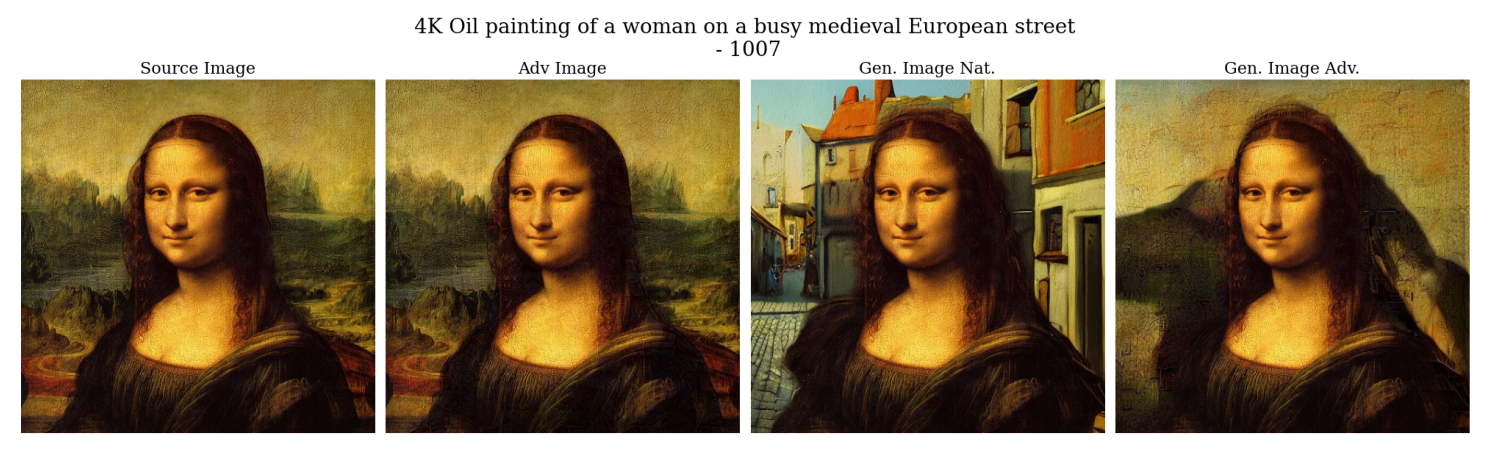

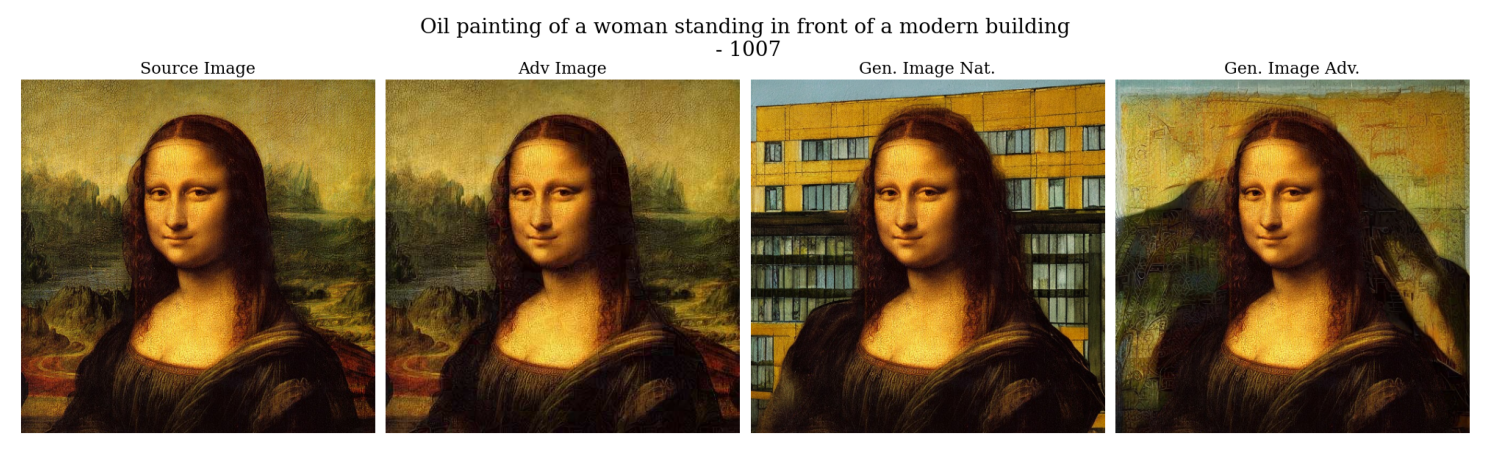

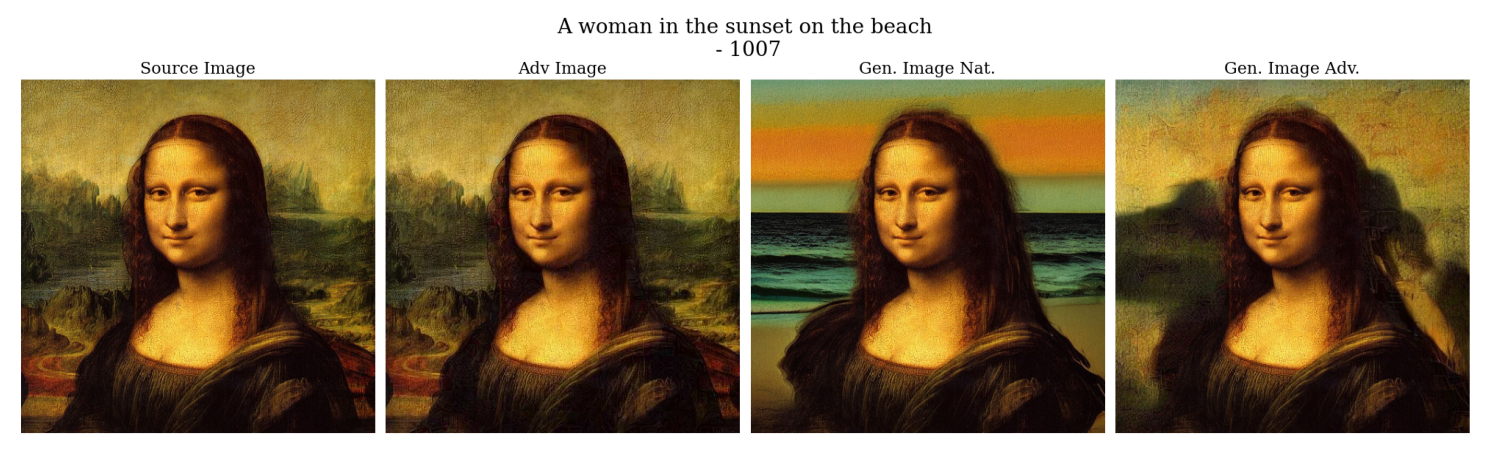

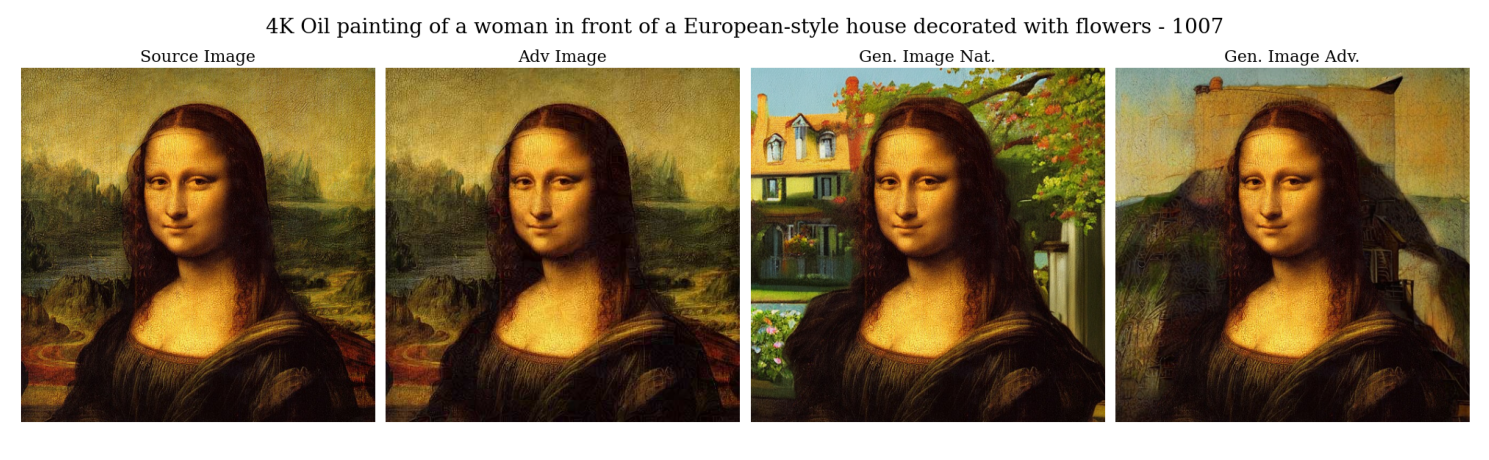

In [ ]:
# Load results from the inference
results = f"{experiment_filename}/jrap_compressed/result_prompt"
for i in range(1, 5):
  image_path = results + str(i) + ".png"
  image = Image.open(image_path)
  plt.figure(figsize=(15, 8))
  plt.imshow(image)
  plt.axis("off")
  plt.tight_layout()
  plt.show()